In [2]:
!pip install aocd
!pip install networkx==3.4
!pip install tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 7.5 MB/s eta 0:00:00a 0:00:01


In [1]:
from collections import defaultdict
from itertools import combinations
from math import log

import aocd
from aocd import submit
from tqdm import tqdm

# from util import lines
import networkx as nx

def lines(d):
    return d.splitlines()

data = aocd.data

In [2]:
input_lines, gates_lines = data.split('\n\n')

def init_graph():
    g = nx.DiGraph()
    
    inp_states = defaultdict(lambda: None)
    for i in lines(input_lines):
        inp, val = i.split(': ')
        inp_states[inp] = int(val)
    
    which_node_outputs_this = dict()
    for idx, i in enumerate(lines(gates_lines)):
        a, out = i.split(' -> ')
        s1, op, s2 = a.split(' ')
        N = f'{op}@{idx}'
        which_node_outputs_this[out] = N
    
    for idx, i in enumerate(lines(gates_lines)):
        a, out = i.split(' -> ')
        s1, op, s2 = a.split(' ')
        N = f'{op}@{idx}'
        alias = s1 if s1[0] == 'x' or s1[0] == 'y' else which_node_outputs_this[s1]
        g.add_edge(alias, N, name=s1)
        alias = s2 if s2[0] == 'x' or s2[0] == 'y' else which_node_outputs_this[s2]
        g.add_edge(alias, N, name=s2)
        for k in which_node_outputs_this.keys():
            if k[0] == 'z':
                g.add_edge(which_node_outputs_this[k], k)
                
    return g, inp_states
    
def calculate(g, inputs):
    d = defaultdict(tuple)
    for pi in nx.topological_sort(nx.line_graph(g)):
        f, t = pi
        if '@' in f:
            assert len(d[f]) == 2, f'{f} -> {t}, {d}'
            a, b = d[f]
            if 'AND' in f:
                d[t] = d[t] + (a & b,)
            elif 'XOR' in f:
                d[t] = d[t] + (a ^ b,)
            elif 'OR' in f:
                d[t] = d[t] + (a | b,)
            else:
                assert False
        else:
            s = inputs[f]
            assert s is not None, f'{f} -> {t}, {inputs}'
            d[t] = d[t] + (s,)
    for k in d.keys():
        if k[0] == 'z':
            inputs[k] = d[k][0]

def load_number(inp, inputs):
    ins = sorted(k for k in inputs.keys() if k[0] == inp)
    m = 0
    accu = 0
    for i in ins:
        accu += inputs[i] * 2 ** m
        m += 1
    return accu


def solve_a():
    inputs = inp_states.copy()
    calculate(g, inputs)
    print('Part A: ' + str(load_number('z', inputs)))


def solve_b():
    pass

#solve_a()
#solve_b()

In [3]:
import random as r
def layout(g):
    res = dict()
    xs = sorted(n for n in g.nodes if n[0] == 'x')
    ys = sorted(n for n in g.nodes if n[0] == 'y')
    zs = sorted(n for n in g.nodes if n[0] == 'z')
    step_z = 10/(len(zs)-1)
    step_x = 10/(len(xs)-1)
    step_y = (2-step_x)/(len(ys)-1)
    
    for i, x in enumerate(xs):
        res[x] = [1, 1 - step_x * i]
    for i, y in enumerate(ys):
        x_pos = res[y.replace('y', 'x')]
        res[y] = [x_pos[0] + step_x/2, x_pos[1] + step_x/2]
    for i, z in enumerate(zs):
        res[z] = [6, 1 - step_z * i]
        
    for i in range(len(xs)):
        x_node = f'x{i:02}'
        for p in sorted(nx.all_simple_paths(g, x_node, f'z{i:02}')):
            step_x = 5/(len(p)-1)
            for j,pi in enumerate(p):
                if pi not in res:
                    res[pi] = [1 + step_x * j, res[x_node][1]]
                    
        next_z = i + 1
        for p in sorted(nx.all_simple_paths(g, x_node, f'z{next_z:02}')):
            step_x = 5/(len(p)-1)
            for j,i in enumerate(p):
                if i not in res:
                    res[i] = [1 + step_x * j, res[x_node][1] - 0.1]
                    
    for i in range(len(ys)):
        y_node = f'y{i:02}'
        for p in sorted(nx.all_simple_paths(g, y_node, f'z{i:02}')):
            step_x = 5/(len(p)-1)
            for j,pi in enumerate(p):
                if pi not in res:
                    res[pi] = [1 + step_x * j, res[y_node][1]]
                    
        next_z = i + 1
        for p in sorted(nx.all_simple_paths(g, y_node, f'z{next_z:02}')):
            step_x = 5/(len(p)-1)
            for j,pi in enumerate(p):
                if pi not in res:
                    res[pi] = [1 + step_x * j, res[y_node][1] - 0.1]

    i = 0
    for n in g.nodes:
        if n not in res:
            i += 1
            res[n] = [-0.25 - 0.5 * 0.5**i, -1 + 0.5 * i]
    
    return res


In [4]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [25, 25]

In [9]:
g, inp_states = init_graph()

def fix_broken_links():
    # Pair 1 (z37,pqt)
    print(g.adj['AND@217'])
    print(g.adj['XOR@182']['OR@147'])
    
    g.remove_edge('XOR@182', 'OR@147')
    g.remove_edge('AND@217', 'z37')
    
    g.add_edge('XOR@182', 'z37')
    g.add_edge('AND@217', 'OR@147')
    
    # Pair 2 (jmv,css)
    print(g.adj['XOR@216']['OR@71'])
    print(g.adj['AND@152']['XOR@204'])
    
    g.remove_edge('XOR@216', 'OR@71') # jmv
    g.remove_edge('AND@152', 'XOR@204') # css
    g.remove_edge('AND@152', 'AND@16') # css
    
    g.add_edge('XOR@216', 'XOR@204')
    g.add_edge('XOR@216', 'AND@16')
    g.add_edge('AND@152', 'OR@71')
    
    # Pair 3
    print(g.adj['XOR@167']['OR@146'])
    print(g.adj['AND@84'])
    
    g.remove_edge('XOR@167', 'OR@146')
    g.remove_edge('AND@84', 'z05')
    
    g.add_edge('XOR@167', 'z05')
    g.add_edge('AND@84', 'OR@146')
    
    # Pair 4 cwt, z09
    print(g.adj['XOR@13'])
    print(g.adj['OR@11'])
    
    g.remove_edge('XOR@13', 'AND@8') 
    g.remove_edge('XOR@13', 'XOR@96')
    g.remove_edge('OR@11', 'z09') 
    
    g.add_edge('XOR@13', 'z09')
    g.add_edge('OR@11', 'AND@8')
    g.add_edge('OR@11', 'XOR@96')
    
    print(','.join(sorted(['z37', 'pqt', 'jmv', 'css', 'gdd', 'z05', 'cwt', 'z09'])))

fix_broken_links()

{'z37': {}}
{'name': 'pqt'}
{'name': 'jmv'}
{'name': 'css'}
{'name': 'gdd'}
{'z05': {}}
{'AND@8': {'name': 'cwt'}, 'XOR@96': {'name': 'cwt'}}
{'z09': {}}
css,cwt,gdd,jmv,pqt,z05,z09,z37


In [10]:
inputs = inp_states.copy()
n1 = load_number('x', inputs)
n2 = load_number('y', inputs)
r = n1 + n2
print(f'{n1} + {n2} = {r}')

rbin_correct = list(map(int, "{0:b}".format(r)))
calculate(g, inputs)
actual_result = load_number('z', inputs)
print('Actual result: ' + str(actual_result))
print(rbin_correct)

rbin_actual = list(map(int, "{0:b}".format(actual_result)))
print(list(map(int, "{0:b}".format(n1))))
print('+')
print(list(map(int, "{0:b}".format(n1))))
print('=')

print(rbin_actual)
print('Instead of')
print(rbin_correct)


27339360157359 + 34293989942303 = 61633350099662
Actual result: 61633350099662
[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0]
[1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1]
+
[1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1]
=
[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0]
Instead of
[1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0]


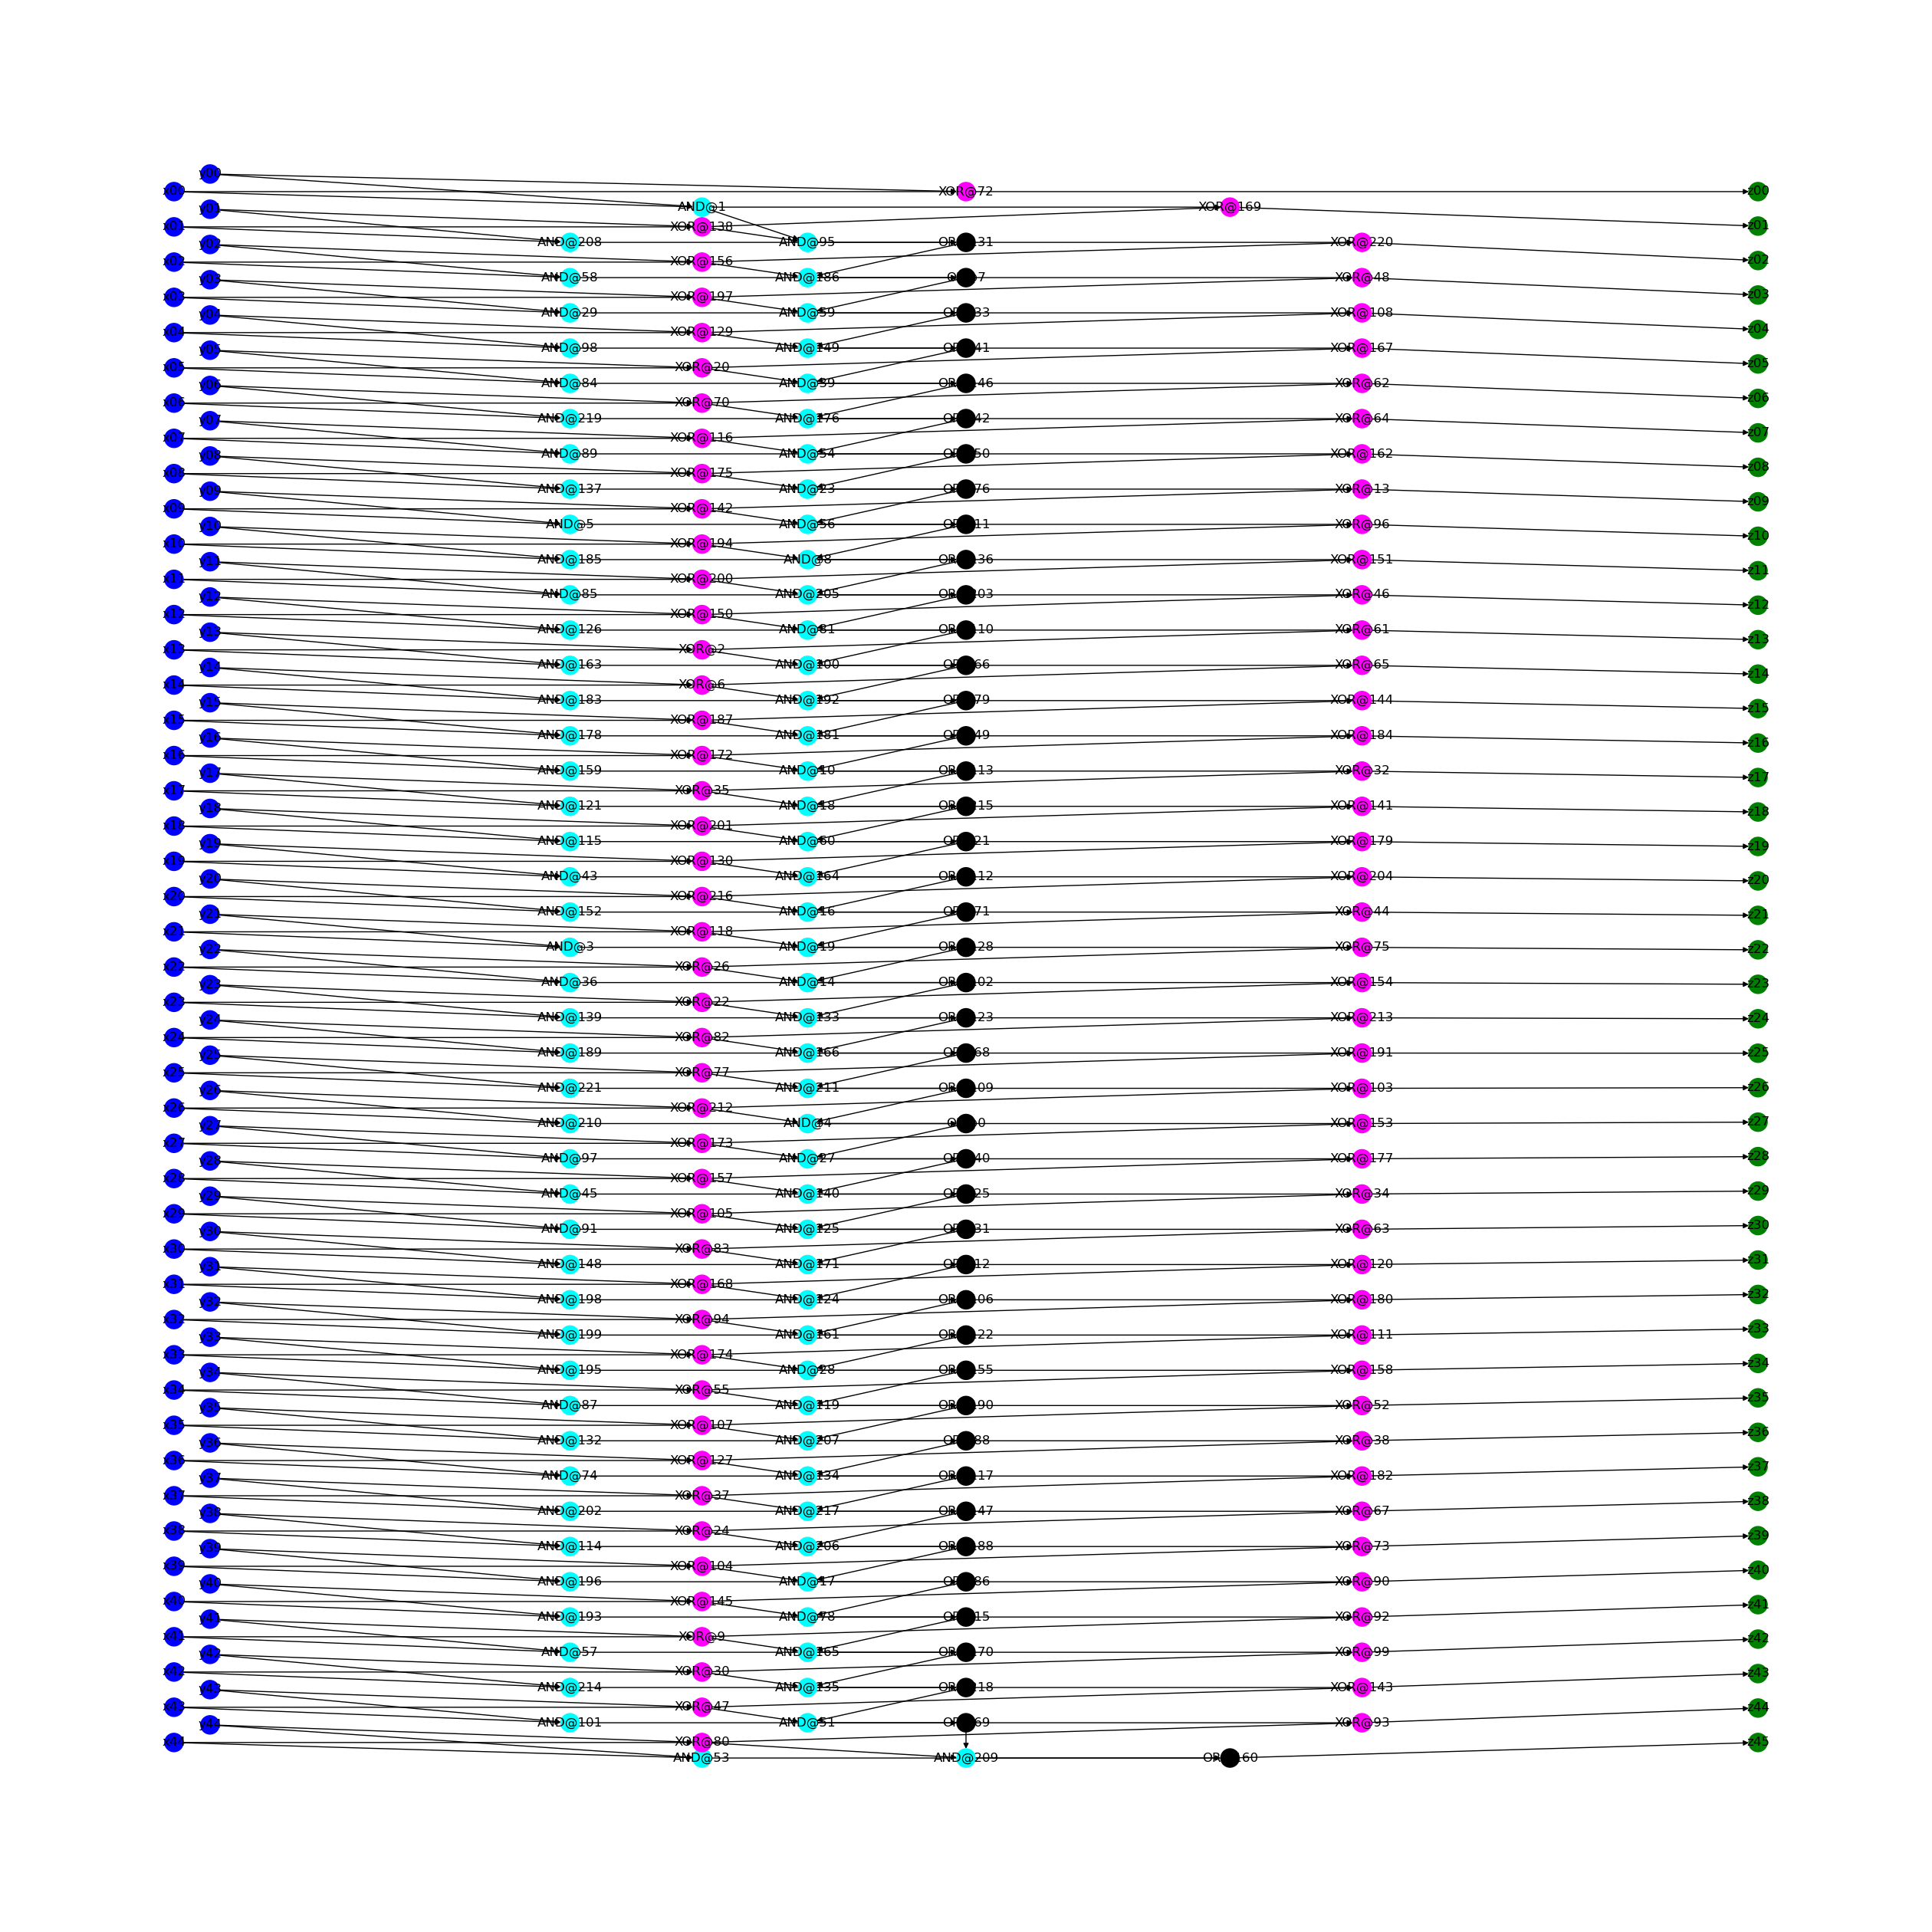

In [11]:
color_map = []
l = len(rbin_correct) - 1
for n in g.nodes:
    if n[0] == 'z':
        idx = int(n[1:])
        if rbin_correct[l - idx] != rbin_actual[l - idx]:
            color_map.append('red')
        else:
            color_map.append('green')
    else:
        if 'AND' in n:
            color_map.append('cyan')
        elif 'XOR' in n:
            color_map.append('magenta')
        elif 'OR' in n:
            color_map.append('black')
        else:
            color_map.append('blue')    

nx.draw(g, layout(g), node_color=color_map, with_labels=True)    